In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from astropy.io import fits
import scipy.sparse
import scipy.linalg
import time

from astropy.io import fits # [added to write outputs. C.M.H.]

r0 = 2.818e-13 # classical electron radius in cm
m_e = 9.10938e-28 # electron mass in gram
c = 2.998e10 # speed of light in cm/s
h = 6.6261e-27 # planck constant in cm^2 g s-1
eV_to_erg = 1.6022e-12
parsec_to_cm = 3.085677581e18 # cm per parsec

kB = 1.3808e-16 # boltzmann constant in cm^2 g s^-2 K^-1
T_CMB = 2.725 # CMB temperature today in K

H_0 = 2.184e-18 # current hubble constant in s^-1
H_r = 3.24076e-18 # 100 km/s/Mpc to 1/s
h_0 = H_0 / H_r
omega_b_0 = 0.0224 / h_0 / h_0  # current baryon abundance
m_p = 1.67262193269e-24 # proton mass in g
G = 6.6743e-8 # gravitational constant in cm^3 g^-1 s^-2
f_He = 0.079 # helium mass fraction
f_H = 0.76 # hydrogen fraction
Y_He = 0.24

E_e = m_e * c * c
rho_crit = 3 * H_0 * H_0 / 8 / np.pi / G
e = 2.718281828459 # base of natural log

z = 2
z2 = (1 + z) / 3
T_CMB *= 1+z # scale to CMB temperature at that redshift <-- C.M.H.

In [2]:
with open('rate_10Mpc.pkl', 'rb') as f:
    rata_arr = pkl.load(f)
    
rate_arr = np.array(rata_arr)
rate_arr = rate_arr.reshape(400,400) # [i][j]: gamma[i] theta[j], rate_arr[-1] = nan
rate_trans = np.transpose(rate_arr) # [i][j]: theta[i] gamma[j], rate_trans[i][-1] = nan
rate_trans[:,-1]=0. # remove nan <-- C.M.H.
fits.PrimaryHDU(rate_trans).writeto('rate_trans.fits', overwrite=True)

gamma_e_arr = np.logspace(8, 14, 400) * eV_to_erg / m_e / c**2 # lab-frame Lorentz factor of the electron produced
theta_e_arr = np.logspace(-8,0, 400)

### generate theta_rms
takes about 20 mins, can read next block directly

In [ ]:
def compton_f(x):
    if x > 1e-2:
        return ((-24 - 144*x - 290*x**2 - 194*x**3 + 20*x**4 + 28*x**5) / 3 / x**2 / (1+2*x)**3 + (4+4*x-x**2) / x**3 * np.log(1+2*x))
    return 8/5*x**2 - 32/5*x**3 + 2248/105*x**4 - 1376/21*x**5 + 11840/63*x**6

def compton_FF(x):
    n = 1024
    y = np.linspace(x / (2 * n), x - x / (2 * n), n)
    result = 0.
    for i in range(n): result += compton_f(y[i]) * y[i]
    result *= x / n
    return result

In [ ]:
jtable = np.loadtxt('EBL_KS18_Q20_z_ 2.0.txt')
nstep = np.shape(jtable)[0] - 1
jtable[:,0] = 2.99792458e18 / jtable[:,0] # convert to Hz
nu = (jtable[:-1,0] + jtable[1:,0]) / 2
dnu = (jtable[:-1,0] - jtable[1:,0])
JnuEBL = (jtable[:-1,1] + jtable[1:,1]) / 2

xx = h*nu/kB/T_CMB
Bnu = 2 * h * nu**3 / c**2 / np.expm1(xx)
Jnu = JnuEBL + Bnu

In [ ]:
n = 400

prefix_sums = [0 for _ in range(n)] # theta_rms from gamma_jp to gamma_j = np.sqrt(prefix[j] - prefix[jp+1])

for j in range(n-1, -1, -1):
    all_int = 0
    factors = Jnu / nu**3 * dnu # <-- updated C.M.H.
    for k in range(nstep):
        all_int += compton_FF(2 * gamma_e_arr[j] * h * nu[k] / m_e / c**2) * factors[k]

    tp2 = 135 * m_e * c**2 / 128 / np.pi**4 / gamma_e_arr[j]**3 * (m_e * c**2 / kB / T_CMB)**4 * all_int
    sumi = tp2 / (m_e * c * gamma_e_arr[j])**2 * np.log(gamma_e_arr[1] / gamma_e_arr[0])

    prefix_sums[j] = sumi

    if j + 1 < n:
        prefix_sums[j] += prefix_sums[j + 1]
    print('prefix_sums[{:3d}]={:12.5E} thetarms={:12.5E} at E={:12.5E} eV'.format(j,prefix_sums[j],prefix_sums[j]**.5,gamma_e_arr[j]*5.11e5)) # <-- C.M.H. inserted
        
np.save("prefix_sums.npy", prefix_sums)

### read theta_rms directly

In [3]:
prefix_sums = np.load("prefix_sums.npy")

In [4]:
def calculate_solid_angles(theta):
    # theta_half[i] = theta[i-1/2]
    theta_half = (theta[1:] + theta[:-1]) / 2
    theta_half = np.concatenate([[theta[0]/2], theta_half, [3*theta[-1]/2 - theta[-2]/2]])

    Omega = 2 * np.pi * (theta_half[2:]**2 - theta_half[:-2]**2) / 2  # solid angles of annulus
    Omega = np.concatenate([Omega, [2 * np.pi * (theta[-1]**2 - theta_half[-2]**2)]])  # add the last circle

    return Omega, theta_half

In [5]:
Omega, theta_half = calculate_solid_angles(theta_e_arr)

In [6]:
M = np.zeros((400, 400))

for i in range(400):
    for j in range(400):
        if j == i + 1:
            M[i, j] = -2 * np.pi / Omega[i] * theta_half[i+1] / (theta_e_arr[i+1] - theta_e_arr[i])
        if j == i - 1:
            M[i, j] = -2 * np.pi / Omega[i] * theta_half[i] / (theta_e_arr[i] - theta_e_arr[i-1])
for i in range(1,399):
    M[i, i] = 2 * np.pi / Omega[i] * (theta_half[i+1] / (theta_e_arr[i+1] - theta_e_arr[i]) + theta_half[i] / (theta_e_arr[i] - theta_e_arr[i-1]))

#M[0, 0] = 0
#M[-1, -1] = 0

M[0,0] = -M[1,0]*Omega[1]/Omega[0]
M[-1,-1] = -M[-2,-1]*Omega[-2]/Omega[-1]
fits.PrimaryHDU(M).writeto('M-matrix.fits', overwrite=True)

### new element of columb

In [7]:
F_NP = np.loadtxt('F_NP.txt')

dk = np.array([F_NP[:, 0][i] - F_NP[:, 0][i-1] for i in range(1, 301)])
dk = np.insert(dk, 0, 0)

k_cut = F_NP[:, 0][-1] # suppose

In [8]:
omega_b = omega_b_0 * (1 + z)**3
mean_n_b = 3 * omega_b * H_0 * H_0 / (8 * np.pi * G * m_p) # mean number density of baryons at the redshift
n_b = mean_n_b # for mean density
    
n_H = n_b * (1 - Y_He) # nuclei in hydrogen
n_He = n_H * f_He # nuclei in helium, assume He is all 4He

n_e = n_H + 2 * n_He # for fully ionized

In [ ]:
nsp = 3 # number of species
mass_sp = np.array([m_e, m_p, 4*m_p]) # masses
nth_sp = np.array([n_e,n_H,n_He]) # number densities
Z_sp = np.array([-1.,1.,2.]) # charges

Z_proj = 1
#v_proj = c
#p_proj = m_e * c

def T(p_proj, v_proj, l):
    #p_proj = m_e * c * gamma
    #v_proj = c / gamma
    co = 2 * np.pi * l**2 * Z_proj**2 * e**4 / (p_proj**2 * v_proj)
    sum_nsp = 0
    gamma_E = np.euler_gamma # Euler's constant
    for a in range(nsp):
        int_FNP = np.sum(dk * F_NP[:, 1] / F_NP[:, 0] + 1 - gamma_E - np.log(h/2/np.pi * k_cut * l / p_proj))
        sum_isp = Z_sp[a]**2 * nth_sp[a] * int_FNP
        sum_nsp += sum_isp
    return co * sum_nsp

In [9]:
nsp = 3 # number of species
mass_sp = np.array([m_e, m_p, 4*m_p]) # masses
nth_sp = np.array([n_e,n_H,n_He]) # number densities
Z_sp = np.array([-1.,1.,2.]) # charges

Z_proj = 1

def T_vectorized(gamma, l):
    p_proj = m_e * c * gamma
    v_proj = c / gamma
    co = 2 * np.pi * l**2 * Z_proj**2 * e**4 / (p_proj**2 * v_proj)
    
    ## vectorize
    gamma_E = np.euler_gamma # Euler's constant
    sum_nsp = np.zeros(gamma.shape) # Initialize sum_nsp as an array of zeros with the same shape as gamma
    
    for a in range(nsp):
        int_FNP = np.sum(dk * F_NP[:, 1] / F_NP[:, 0] + 1 - gamma_E - np.log(h/2/np.pi * k_cut * l / p_proj[:, np.newaxis]), axis=1)
        sum_isp = Z_sp[a]**2 * nth_sp[a] * int_FNP
        sum_nsp += sum_isp
    
    return co * sum_nsp

In [10]:
eigenvalues, eigenvectors = np.linalg.eig(M)

V = eigenvectors

A = np.diag(eigenvalues) # sqrt(A[i][i])

V_inv = np.linalg.inv(V)

#diagonalized_M = np.dot(np.dot(V, A), V_inv)

# print("Diagonalized Matrix:")
# print(diagonalized_M)

In [18]:
def T_ij(l, i ,j):
    Gamma_IC0 = 1.1e-18 * z2**4
    gamma_ij = gamma_e_arr[i:j+1]
    d_gamma_e = np.insert(np.diff(gamma_ij), 0, 0)
    Tl = T_vectorized(gamma_ij, l)
    #print(Tl.shape, d_gamma_e.shape, gamma_ij.shape)
    return -np.sum(Tl * d_gamma_e / Gamma_IC0 / gamma_ij**2)

In [12]:
def get_nij(i, j, t, M_expm): # nij = dN / (dV dgammae_j dOmegae_i)
    Gamma_IC0 = 1.1e-18 * z2**4
    gamma_max_inv = 1. / gamma_e_arr[j] - Gamma_IC0 * t
    if gamma_max_inv>1e-99:
        gamma_max = 1./gamma_max_inv
    else:
        gamma_max = 1e99
        
    nij = 0
    
    for jp in range(j, 399):
        if gamma_e_arr[jp] <= gamma_max:
            # THIS IS A COMMENT: rate_trans_smoothed = M_expm @ rate_trans
            # Then, rate_trans_smoothed[i][jp] is the dot product of M_expm[jp][i] and rate_trans[:, jp]
            rate_trans_smoothed_ijp = np.dot(M_expm[jp, i, :], rate_trans[:, jp])
                
            sum_ij = (gamma_e_arr[jp] - gamma_e_arr[jp-1]) * rate_trans_smoothed_ijp
            
            if gamma_e_arr[jp+1] > gamma_max:
                fraction = (gamma_max - gamma_e_arr[jp]) / (gamma_e_arr[jp+1] - gamma_e_arr[jp])
                sum_ij = sum_ij * fraction
            nij += sum_ij
    nij = nij / (Gamma_IC0 * gamma_e_arr[j]**2)
    return nij

In [13]:
def get_ni(i, nij): # integrate gamma_e (1/gamma_e) nij
    ni = 0
    for j in range(1, 400):
        sum_i = (gamma_e_arr[j] - gamma_e_arr[j-1]) / gamma_e_arr[j] * nij[i][j]
        ni += sum_i
    return ni

In [14]:
#t_arr = [1e8, 5e8, 1e9, 5e9, 1e10, 5e10, 1e11, 5e11, 1e12, 5e12, 1e13]
t_arr = [1e8, 1e9, 1e10, 1e11, 1e12, 1e13] # To save time, I cut it short
t_num = len(t_arr)

In [15]:
Omega_x = np.logspace(-8,0, 400).reshape(400, 1)

In [16]:
l = np.array([np.sqrt(A[i][i]) for i in range(len(A))])
#print(l)

In [17]:
T_ij(l[0], 0, 10)

(11,) (11,) (11,)


-3.3305388537786313e+55

In [19]:
nij = np.zeros((t_num, 400, 400))
time_start = time.time()
for k in range(t_num):
    print(f'time {k} {t_arr[k]:.1e}', end = ' ')
    
    for j in range(1, 400):
        print(f'j = {j}, time = {(time.time()-time_start)/60}')
        M_new = np.zeros((400, 400, 400))
        for jp in range(j, 399):
            theta_rms = np.sqrt(prefix_sums[j] - prefix_sums[jp+1]) # from jp to j
            M_expm = scipy.linalg.expm(-theta_rms**2/4 * M)
            
            ### new element for columb scattering
            new_EV = np.zeros((len(l)))
            for x in range(len(l)):
                new_EV[x] = np.exp(T_ij(l[x], j, jp)) # from jp to j
            new_D = np.diag(new_EV)
            columb = np.dot(np.dot(V, new_D), V_inv)
            
            M_new[jp] = M_expm @ columb
            
            if np.isnan(M_new[jp,:,:].any()): print('test', j, jp, np.isnan(M_new[jp,:,:].any()))

        for i in range(400):
            nij[k][i][j-1] = get_nij(i, j, t_arr[k], M_new)
    print('t = ', (time.time() - time_start) / 60)

time 0 1.0e+08 j = 1, time = 6.536642710367839e-06
j = 2, time = 1.3307154536247254
j = 3, time = 2.6251099189122518
j = 4, time = 3.885447903474172
j = 5, time = 5.138812820116679
j = 6, time = 6.396208822727203
j = 7, time = 7.644082971413931
j = 8, time = 8.880038305123646
j = 9, time = 10.102098135153453
j = 10, time = 11.274700268109639
j = 11, time = 12.436885404586793
j = 12, time = 13.645139034589132
j = 13, time = 14.86137450536092
j = 14, time = 16.073973500728606
j = 15, time = 17.2825123389562
j = 16, time = 18.475087702274323
j = 17, time = 19.666586236159006
j = 18, time = 20.842591389020285
j = 19, time = 21.98710963726044
j = 20, time = 23.172779071331025
j = 21, time = 24.341886234283447
j = 22, time = 25.508757551511128
j = 23, time = 26.6681401014328
j = 24, time = 27.82756040096283
j = 25, time = 28.974160770575207
j = 26, time = 30.121266849835713
j = 27, time = 31.259925802548725
j = 28, time = 32.39989882310231
j = 29, time = 33.5229972521464
j = 30, time = 34.65

In [20]:
## save data

fits.PrimaryHDU(nij).writeto('nij.fits', overwrite=True)

In [21]:
print(nij)

[[[ 3.70156692e-32  4.03044703e-32  4.39347065e-32 ...  6.94618947e-31
    0.00000000e+00  0.00000000e+00]
  [ 3.70156692e-32  4.03044703e-32  4.39347065e-32 ...  5.82225463e-31
    0.00000000e+00  0.00000000e+00]
  [ 3.70156692e-32  4.03044703e-32  4.39347065e-32 ...  4.87024651e-31
    0.00000000e+00  0.00000000e+00]
  ...
  [ 4.46447713e-46  3.97913556e-46  3.54576554e-46 ...  3.30176901e-60
    0.00000000e+00  0.00000000e+00]
  [ 3.28920444e-46  2.93158916e-46  2.61351302e-46 ... -7.51056739e-61
    0.00000000e+00  0.00000000e+00]
  [ 2.42504203e-46  2.16149259e-46  1.92730654e-46 ...  2.25435052e-60
    0.00000000e+00  0.00000000e+00]]

 [[ 3.70156765e-31  4.03044785e-31  4.39347159e-31 ...  1.15248657e-30
    0.00000000e+00  0.00000000e+00]
  [ 3.70156765e-31  4.03044785e-31  4.39347159e-31 ...  9.66007376e-31
    0.00000000e+00  0.00000000e+00]
  [ 3.70156765e-31  4.03044785e-31  4.39347159e-31 ...  8.08053641e-31
    0.00000000e+00  0.00000000e+00]
  ...
  [ 4.46447801e-45  3.9

In [22]:
ni = np.zeros((t_num, 400)) # about theta
for k in range(t_num):
    for i in range(400):
        ni[k][i] = get_ni(i, nij[k])

In [23]:
mc = np.zeros((400, t_num+1))
mc[:,0] = theta_e_arr
mc[:,1:] = ni.T
#np.savetxt('ni.dat', mc)

In [24]:
deriv_array = np.zeros((400,t_num))
for j in range(399):
    for jp in range(j,399):
        if j==jp:
            tr = 0.
        else:
            tr = np.arccosh(theta_e_arr[jp]/theta_e_arr[j])
        deriv_array[j,:] += 2 * theta_e_arr[j] * (ni[:,jp+1]-ni[:,jp])/(theta_e_arr[jp+1]-theta_e_arr[jp])\
          * (np.arccosh(theta_e_arr[jp+1]/theta_e_arr[j]) - tr)
mc2 = np.zeros((400, t_num+1))
mc2[:,0] = theta_e_arr
mc2[:,1:] = deriv_array
np.savetxt('deriv_array.dat', mc2)

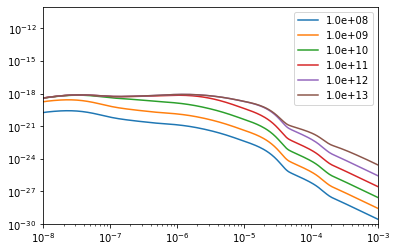

In [25]:
for i in range(t_num):
    plt.plot(Omega_x, -deriv_array[:, i], label=f'{t_arr[i]:.1e}')
    
plt.legend(loc = 'upper right')
plt.xlim([1e-8, 1e-3])
plt.ylim([1e-30, 1e-10])
plt.xscale('log')
plt.yscale('log')
plt.show()